In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os 
import xgboost as xgb
import sys
sys.path.append('..')
from xgb_wrappers.gradient_boosted_trees import GradientBoostedTreesModel
from xgb_wrappers.random_forest import RandomForestModel
from tools.bias_utils import add_demographic_data, to_dmatrix, logit, inv_logit, r2_score
import json

/Users/ebensen/opt/anaconda3/envs/ai_bias/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Load Data

In [3]:
models = ['xgb', 'rf', 'gbt']
corrections = ['pearson', 'kendall', 'distance']
demographic = 'MINRTY'
x_axis_as_increase = False
correction_data = None
for model in models:
    for correction in corrections:
        path = os.path.join(f'results_{model}', correction, 'MINRTY', 'gamma_sweep.csv')
        temp = pd.read_csv(path)
        cols = list(temp.columns)
        temp['model'] = model
        temp['correction'] = correction
        temp = temp[['model', 'correction'] + cols]
        if correction_data is None:
            correction_data = temp
        else:
            correction_data = pd.concat([correction_data, temp], axis=0)

if True: #0.0 not in correction_data['gamma'].values:
    results = pd.DataFrame({'model':['xgb', 'rf', 'gbt'], 'correction':['none' for _ in range(3)], 
                            'gamma':np.zeros(3), 'test_mae':np.zeros(3), 'test_r2':np.zeros(3),
                            'test_rmse':np.zeros(3), 'test_mape':np.zeros(3),
                            'r2_0 0.6':np.zeros(3), 'r2_0 0.7':np.zeros(3), 'r2_0 0.8':np.zeros(3),
                            'r2_0 0.9':np.zeros(3), 'r2_1 0.6':np.zeros(3), 'r2_1 0.7':np.zeros(3), 
                            'r2_1 0.8':np.zeros(3), 'r2_1 0.9':np.zeros(3), 'r2 diff 0.6':np.zeros(3),
                            'r2 diff 0.7':np.zeros(3), 'r2 diff 0.8':np.zeros(3), 'r2 diff 0.9':np.zeros(3)})
    
    cols_drop = ['Date', 'FC', 'PenRate', 'NumberOfLanes', 'Dir', 'Lat', 'Long']

    raw_data_train = pd.read_csv("../data/final_train_data.csv")
    raw_data_test = pd.read_csv("../data/final_test_data.csv")
    raw_data_test1 = pd.DataFrame(np.concatenate((raw_data_test.values, np.zeros(raw_data_test.shape[0]).reshape(-1, 1)), axis=1),
                                    columns = raw_data_test.columns.append(pd.Index(['fold'])))
    raw_data = pd.DataFrame(np.concatenate((raw_data_train.values, raw_data_test1.values), axis=0), 
                            columns = raw_data_train.columns)

    raw_data = add_demographic_data(raw_data, demographic, loc='../data/off_freeway_station_demographics.csv')
    raw_data = raw_data.dropna()
    raw_data_train = raw_data.loc[raw_data.fold!=0, :]
    raw_data_test = raw_data.loc[raw_data.fold==0, :]
    data = raw_data.drop(cols_drop, axis=1)
    if 'Dir' in data.columns:
        one_hot = pd.get_dummies(data[['Dir']])
        data = data.drop(['Dir'], axis = 1)
        data = data.join(one_hot)
    week_dict = {"DayOfWeek": {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 
                                'Friday': 5, 'Saturday': 6, 'Sunday': 7}}
    data = data.replace(week_dict)

    X = data.drop(['Volume'], axis=1)
    y = data[['Volume']]

    X_test = X.loc[X.fold==0, :]
    dem_test = X_test[[demographic]].values.flatten()
    X_test = X_test.drop(['fold', 'StationId'], axis = 1).values
    y_test = y.loc[X.fold==0, :].values.flatten()
    dtest = xgb.DMatrix(X_test, label=y_test)

    # XGB base
    model_path = os.path.join('..', 'base_models', 'xgb', 'base_xgb.model')
    params_path = os.path.join('..', 'base_models', 'xgb', 'params.json')
    with open(params_path) as f:
        params = json.load(f)
    n_estimators = 100*int(params['n'])
    lr = 10**params['p']
    depth = int(params['depth'])
    gamma = 10**params['g']
    subsample = params['subsample']
    colsample = params['colsample']
    min_cw = params['min_cw']
    params = {'learning_rate':lr, 'max_depth':depth, 'n_jobs':-1, 'gamma':gamma, 'min_child_weight':min_cw,
        'subsample':subsample, 'colsample_bytree':colsample, 'random_state':1234}
    xgb_model = xgb.Booster(params)
    xgb_model.load_model(model_path)
    preds = xgb_model.predict(dtest).flatten()
    results.loc[0, 'test_mae'] = np.mean(np.abs(preds - y_test))
    results.loc[0, 'test_r2'] = r2_score(y_test, preds)
    results.loc[0, 'test_rmse'] = np.sqrt(np.mean((preds - y_test)**2))
    results.loc[0, 'test_mape'] = np.mean(np.abs(preds - y_test)/y_test)
    for c in [0.6, 0.7, 0.8, 0.9]:
        inds = dem_test < c 
        results.loc[0, f'r2_0 {c}'] = r2_score(y_test[inds], preds[inds])
        results.loc[0, f'r2_1 {c}'] = r2_score(y_test[~inds], preds[~inds])
        results.loc[0, f'r2 diff {c}'] = abs(results.loc[0, f'r2_1 {c}'] - results.loc[0, f'r2_0 {c}'])

    # RF base
    model_path = os.path.join('..', 'base_models', 'rf', 'base_rf.model')
    params_path = os.path.join('..', 'base_models', 'rf', 'params.json')
    with open(params_path) as f:
        params = json.load(f)
    n_estimators = 100*int(params['n'])
    depth = int(params['depth'])
    gamma = 10**params['g']
    min_cw = params['min_cw']
    subsample = params['subsample']
    colsample = params['colsample']
    params = {'n_estimators':n_estimators, 'max_depth':depth, 'nthread':-1, 'gamma':gamma, 'min_child_weight':min_cw,
                'subsample':subsample, 'colsample_bytree':colsample, 'random_state':1234}
    rf_model = RandomForestModel(**params)
    rf_model.load_model(model_path)
    preds = rf_model.predict(dtest).flatten()
    results.loc[1, 'test_mae'] = np.mean(np.abs(preds - y_test))
    results.loc[1, 'test_r2'] = r2_score(y_test, preds)
    results.loc[1, 'test_rmse'] = np.sqrt(np.mean((preds - y_test)**2))
    results.loc[1, 'test_mape'] = np.mean(np.abs(preds - y_test)/y_test)
    for c in [0.6, 0.7, 0.8, 0.9]:
        inds = dem_test < c 
        results.loc[1, f'r2_0 {c}'] = r2_score(y_test[inds], preds[inds])
        results.loc[1, f'r2_1 {c}'] = r2_score(y_test[~inds], preds[~inds])
        results.loc[1, f'r2 diff {c}'] = abs(results.loc[1, f'r2_1 {c}'] - results.loc[1, f'r2_0 {c}'])

    # GBT base
    model_path = os.path.join('..', 'base_models', 'gbt', 'base_gbt.model')
    params_path = os.path.join('..', 'base_models', 'gbt', 'params.json')
    with open(params_path) as f:
        params = json.load(f)
    n_estimators = 100*int(params['n'])
    lr = 10**params['p']
    depth = int(params['depth'])
    min_cw = params['min_cw']
    subsample = params['subsample']
    colsample = params['colsample']
    params = {'num_boost_round':n_estimators, 'eta':lr, 'max_depth':depth, 'nthread':-1, 'min_child_weight':min_cw,
                        'subsample':subsample, 'colsample_bytree':colsample, 'random_state':1234}
    gbt_model = GradientBoostedTreesModel(**params)
    gbt_model.load_model(model_path)
    preds = gbt_model.predict(dtest).flatten()
    results.loc[2, 'test_mae'] = np.mean(np.abs(preds - y_test))
    results.loc[2, 'test_r2'] = r2_score(y_test, preds)
    results.loc[2, 'test_rmse'] = np.sqrt(np.mean((preds - y_test)**2))
    results.loc[2, 'test_mape'] = np.mean(np.abs(preds - y_test)/y_test)
    for c in [0.6, 0.7, 0.8, 0.9]:
        inds = dem_test < c 
        results.loc[2, f'r2_0 {c}'] = r2_score(y_test[inds], preds[inds])
        results.loc[2, f'r2_1 {c}'] = r2_score(y_test[~inds], preds[~inds])
        results.loc[2, f'r2 diff {c}'] = abs(results.loc[2, f'r2_1 {c}'] - results.loc[2, f'r2_0 {c}'])

    correction_data = pd.concat([correction_data, results], axis=0)

data = correction_data.reset_index(drop=True)
data = data.sort_values(by=['model', 'gamma'])
data.to_csv('gamma_sweep_combined.csv')
# print(results['gamma'].min())
data.head()


,model,correction,gamma,test_mae,test_r2,test_rmse,test_mape,r2_0 0.6,r2_0 0.7,r2_0 0.8,r2_0 0.9,r2_1 0.6,r2_1 0.7,r2_1 0.8,r2_1 0.9,r2 diff 0.6,r2 diff 0.7,r2 diff 0.8,r2 diff 0.9
355,gbt,pearson,0.0,50.098595,0.873607,98.322819,0.905403,0.920206,0.918213,0.908224,0.905683,0.826762,0.812368,0.694913,0.505746,0.093444,0.105845,0.213311,0.399937
456,gbt,distance,0.0,50.022151,0.874136,98.113655,0.892969,0.921763,0.919440,0.908883,0.906430,0.825927,0.811795,0.694908,0.503902,0.095836,0.107645,0.213974,0.402528
459,gbt,none,0.0,50.181066,0.873460,98.373772,0.906554,0.921458,0.919382,0.907938,0.905607,0.824806,0.809951,0.695877,0.505375,0.096652,0.109431,0.212060,0.400233
305,gbt,pearson,0.5,49.849504,0.873957,98.048324,0.888656,0.920239,0.918426,0.909551,0.907019,0.827359,0.812441,0.690528,0.495234,0.092879,0.105985,0.219022,0.411785
356,gbt,kendall,0.5,49.524732,0.835885,99.824392,0.937875,0.901704,0.901049,0.885185,0.877772,0.749707,0.714120,0.503744,0.201742,0.151997,0.186929,0.381441,0.676030


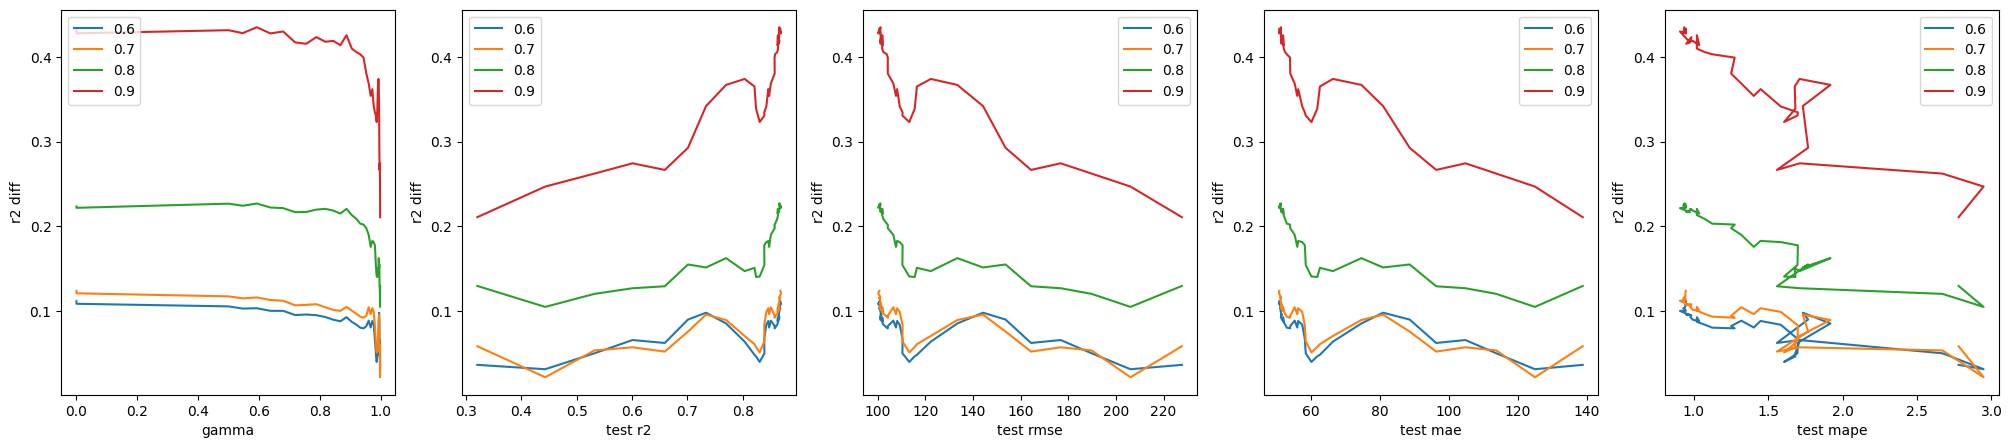

In [4]:
model = 'xgb'
correction = 'distance' 
inds = (data['model'] == model) & ((data['correction'] == correction) | (data['correction'] == 'none'))
temp = data[inds]
temp = temp[temp['test_r2'] > 0]

fig, axs = plt.subplots(1, 5, figsize=(25, 5))
axs[0].plot(temp['gamma'], temp['r2 diff 0.6'], label='0.6')
axs[0].plot(temp['gamma'], temp['r2 diff 0.7'], label='0.7')
axs[0].plot(temp['gamma'], temp['r2 diff 0.8'], label='0.8')
axs[0].plot(temp['gamma'], temp['r2 diff 0.9'], label='0.9')
axs[0].set_xlabel('gamma')
axs[0].set_ylabel('r2 diff')
axs[0].legend()
axs[1].plot(temp['test_r2'], temp['r2 diff 0.6'], label='0.6')
axs[1].plot(temp['test_r2'], temp['r2 diff 0.7'], label='0.7')
axs[1].plot(temp['test_r2'], temp['r2 diff 0.8'], label='0.8')
axs[1].plot(temp['test_r2'], temp['r2 diff 0.9'], label='0.9')
axs[1].set_xlabel('test r2')
axs[1].set_ylabel('r2 diff')
axs[1].legend()
axs[2].plot(temp['test_rmse'], temp['r2 diff 0.6'], label='0.6')
axs[2].plot(temp['test_rmse'], temp['r2 diff 0.7'], label='0.7')
axs[2].plot(temp['test_rmse'], temp['r2 diff 0.8'], label='0.8')
axs[2].plot(temp['test_rmse'], temp['r2 diff 0.9'], label='0.9')
axs[2].set_xlabel('test rmse')
axs[2].set_ylabel('r2 diff')
axs[2].legend()
axs[3].plot(temp['test_mae'], temp['r2 diff 0.6'], label='0.6')
axs[3].plot(temp['test_mae'], temp['r2 diff 0.7'], label='0.7')
axs[3].plot(temp['test_mae'], temp['r2 diff 0.8'], label='0.8')
axs[3].plot(temp['test_mae'], temp['r2 diff 0.9'], label='0.9')
axs[3].set_xlabel('test mae')
axs[3].set_ylabel('r2 diff')
axs[3].legend()
axs[4].plot(temp['test_mape'], temp['r2 diff 0.6'], label='0.6')
axs[4].plot(temp['test_mape'], temp['r2 diff 0.7'], label='0.7')
axs[4].plot(temp['test_mape'], temp['r2 diff 0.8'], label='0.8')
axs[4].plot(temp['test_mape'], temp['r2 diff 0.9'], label='0.9')
axs[4].set_xlabel('test mape')
axs[4].set_ylabel('r2 diff')
axs[4].legend()
plt.savefig('gamma_sweep.png')
plt.show()

# Troubleshooting

In [5]:
test_path = os.path.join('results_1.0', 'xgb', 'distance', 'MINRTY')
test_model = xgb.Booster()
test_model.load_model(os.path.join(test_path, 'corrected.model'))
with open(os.path.join(test_path, 'gamma_params.json')) as f:
    gamma = inv_logit(json.load(f)['correction_gamma'])
preds = test_model.predict(dtest).flatten()

In [6]:
def r2_diff(preds, demos, cutoff):
    inds = demos < cutoff
    r2_0 = r2_score(y_test[inds], preds[inds])
    r2_1 = r2_score(y_test[~inds], preds[~inds])
    return abs(r2_1 - r2_0)

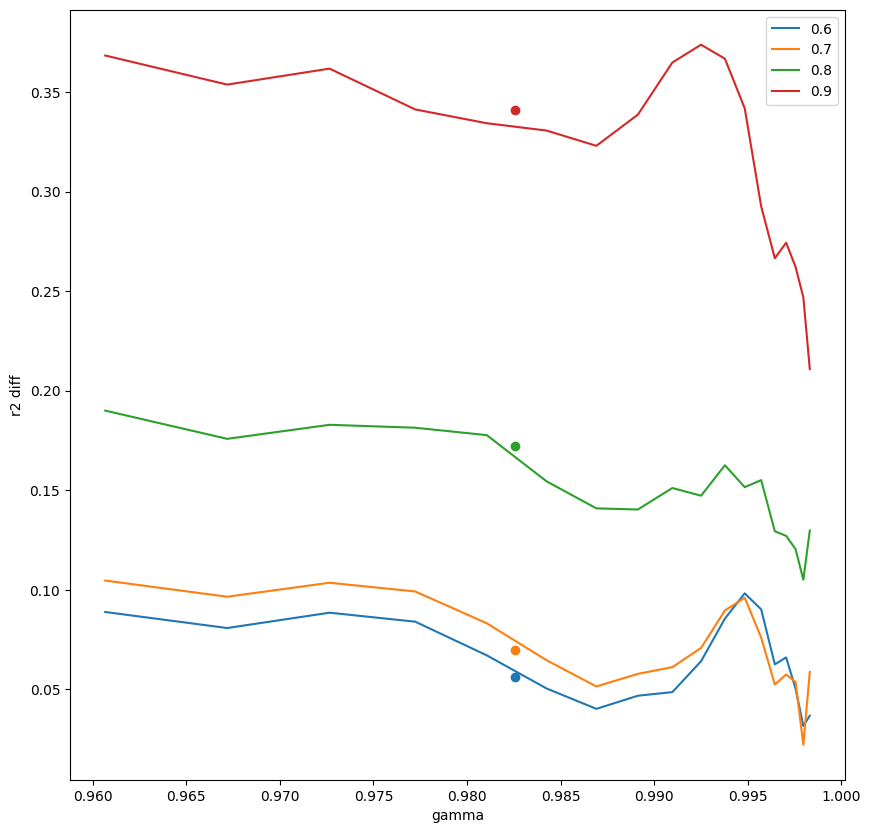

In [7]:
temp = temp[temp['gamma'] > 0.96]
plt.figure(figsize=(10, 10))
plt.plot(temp['gamma'], temp['r2 diff 0.6'], label='0.6')
plt.scatter(gamma, r2_diff(preds, dem_test, 0.6))
plt.plot(temp['gamma'], temp['r2 diff 0.7'], label='0.7')
plt.scatter(gamma, r2_diff(preds, dem_test, 0.7))
plt.plot(temp['gamma'], temp['r2 diff 0.8'], label='0.8')
plt.scatter(gamma, r2_diff(preds, dem_test, 0.8))
plt.plot(temp['gamma'], temp['r2 diff 0.9'], label='0.9')
plt.scatter(gamma, r2_diff(preds, dem_test, 0.9))
plt.xlabel('gamma')
plt.ylabel('r2 diff')
plt.legend()
plt.show()

# Trends

In [8]:
x_axis = 'gamma'

xgb_data = data[data['model'] == 'xgb']
xgb_data = xgb_data.sort_values(by=[x_axis])
xgb_initial = xgb_data[xgb_data['gamma'] == 0.0][x_axis].values[0] if x_axis_as_increase else 0.0
# print(xgb_initial)
rf_data = data[data['model'] == 'rf']
rf_data = rf_data.sort_values(by=[x_axis])
rf_initial = rf_data[rf_data['gamma'] == 0.0][x_axis].values[0] if x_axis_as_increase else 0.0
gbt_data = data[data['model'] == 'gbt']
gbt_data = gbt_data.sort_values(by=[x_axis])
gbt_initial = gbt_data[gbt_data['gamma'] == 0.0][x_axis].values[0] if x_axis_as_increase else 0.0
data_dict = {'xgb': xgb_data, 'rf': rf_data, 'gbt': gbt_data}

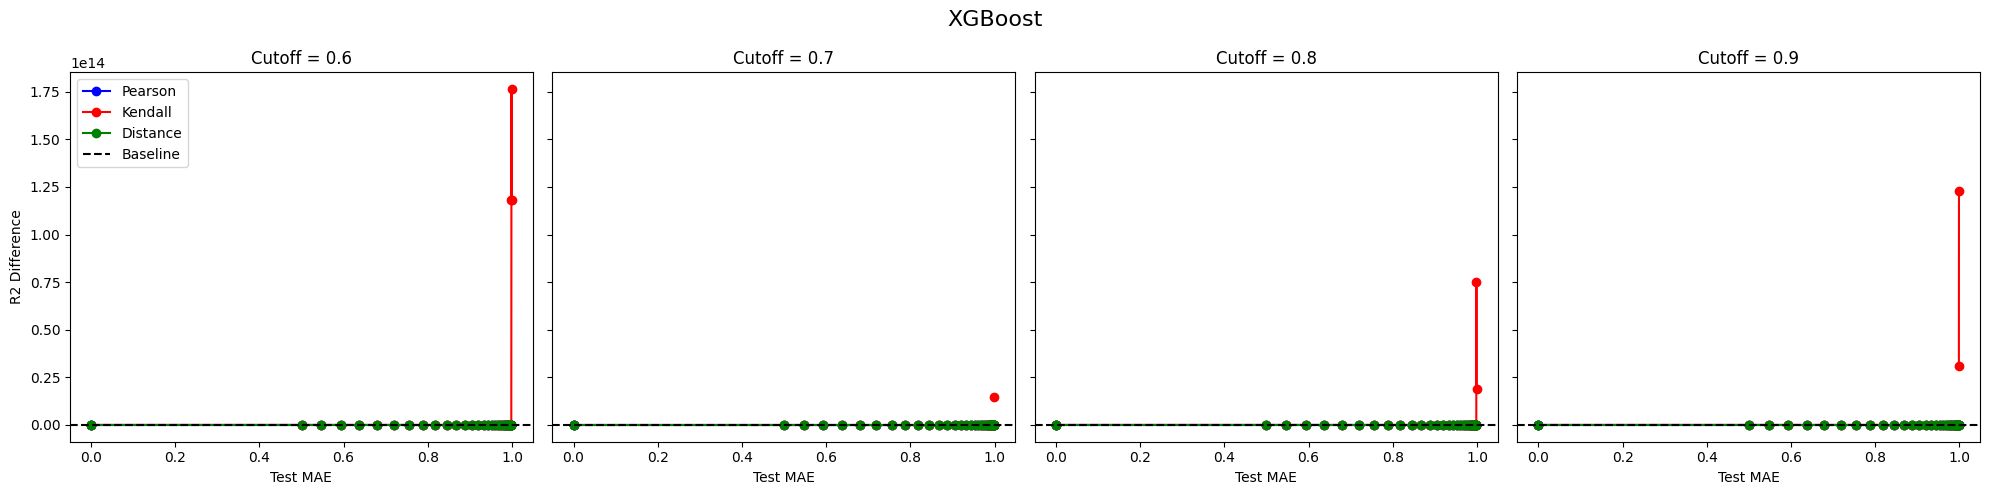

In [9]:
cut_inds = xgb_data[x_axis] < 200
pearson_inds = (xgb_data['correction'] == 'pearson') | (xgb_data['correction'] == 'none')
kendall_inds = (xgb_data['correction'] == 'kendall') | (xgb_data['correction'] == 'none')
distance_inds = (xgb_data['correction'] == 'distance') | (xgb_data['correction'] == 'none')
pearson_inds &= cut_inds
kendall_inds &= cut_inds
distance_inds &= cut_inds

fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
ax[0].plot(xgb_data[pearson_inds][x_axis] - xgb_initial, xgb_data[pearson_inds]['r2 diff 0.6'], label='Pearson', color='blue', marker='o')
ax[1].plot(xgb_data[pearson_inds][x_axis] - xgb_initial, xgb_data[pearson_inds]['r2 diff 0.7'], color='blue', marker='o')
ax[2].plot(xgb_data[pearson_inds][x_axis] - xgb_initial, xgb_data[pearson_inds]['r2 diff 0.8'], color='blue', marker='o')
ax[3].plot(xgb_data[pearson_inds][x_axis] - xgb_initial, xgb_data[pearson_inds]['r2 diff 0.9'], color='blue', marker='o')
ax[0].plot(xgb_data[kendall_inds][x_axis] - xgb_initial, xgb_data[kendall_inds]['r2 diff 0.6'], label='Kendall', color='red', marker='o')
ax[1].plot(xgb_data[kendall_inds][x_axis] - xgb_initial, xgb_data[kendall_inds]['r2 diff 0.7'], color='red', marker='o')
ax[2].plot(xgb_data[kendall_inds][x_axis] - xgb_initial, xgb_data[kendall_inds]['r2 diff 0.8'], color='red', marker='o')
ax[3].plot(xgb_data[kendall_inds][x_axis] - xgb_initial, xgb_data[kendall_inds]['r2 diff 0.9'], color='red', marker='o')
ax[0].plot(xgb_data[distance_inds][x_axis] - xgb_initial, xgb_data[distance_inds]['r2 diff 0.6'], label='Distance', color='green', marker='o')
ax[1].plot(xgb_data[distance_inds][x_axis] - xgb_initial, xgb_data[distance_inds]['r2 diff 0.7'], color='green', marker='o')
ax[2].plot(xgb_data[distance_inds][x_axis] - xgb_initial, xgb_data[distance_inds]['r2 diff 0.8'], color='green', marker='o')
ax[3].plot(xgb_data[distance_inds][x_axis] - xgb_initial, xgb_data[distance_inds]['r2 diff 0.9'], color='green', marker='o')
# Plot dotted baseline at initial point
ax[0].axhline(y=xgb_data['r2 diff 0.6'].iloc[0], linestyle='--', color='black', label='Baseline')
ax[1].axhline(y=xgb_data['r2 diff 0.7'].iloc[0], linestyle='--', color='black')
ax[2].axhline(y=xgb_data['r2 diff 0.8'].iloc[0], linestyle='--', color='black')
ax[3].axhline(y=xgb_data['r2 diff 0.9'].iloc[0], linestyle='--', color='black')

for a in ax:
    a.set_xlabel('Test MAE')
    if x_axis_as_increase:
        a.set_xscale('log')
    # a.set_ylim(-0.02, 0.55)
ax[0].set_ylabel('R2 Difference')
ax[0].set_title('Cutoff = 0.6')
ax[0].legend()
ax[1].set_title('Cutoff = 0.7')
ax[2].set_title('Cutoff = 0.8')
ax[3].set_title('Cutoff = 0.9')
# Set figure title
fig.suptitle('XGBoost', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('.', 'figures', 'xgb_mae.png'), dpi=300, bbox_inches='tight')
plt.show()

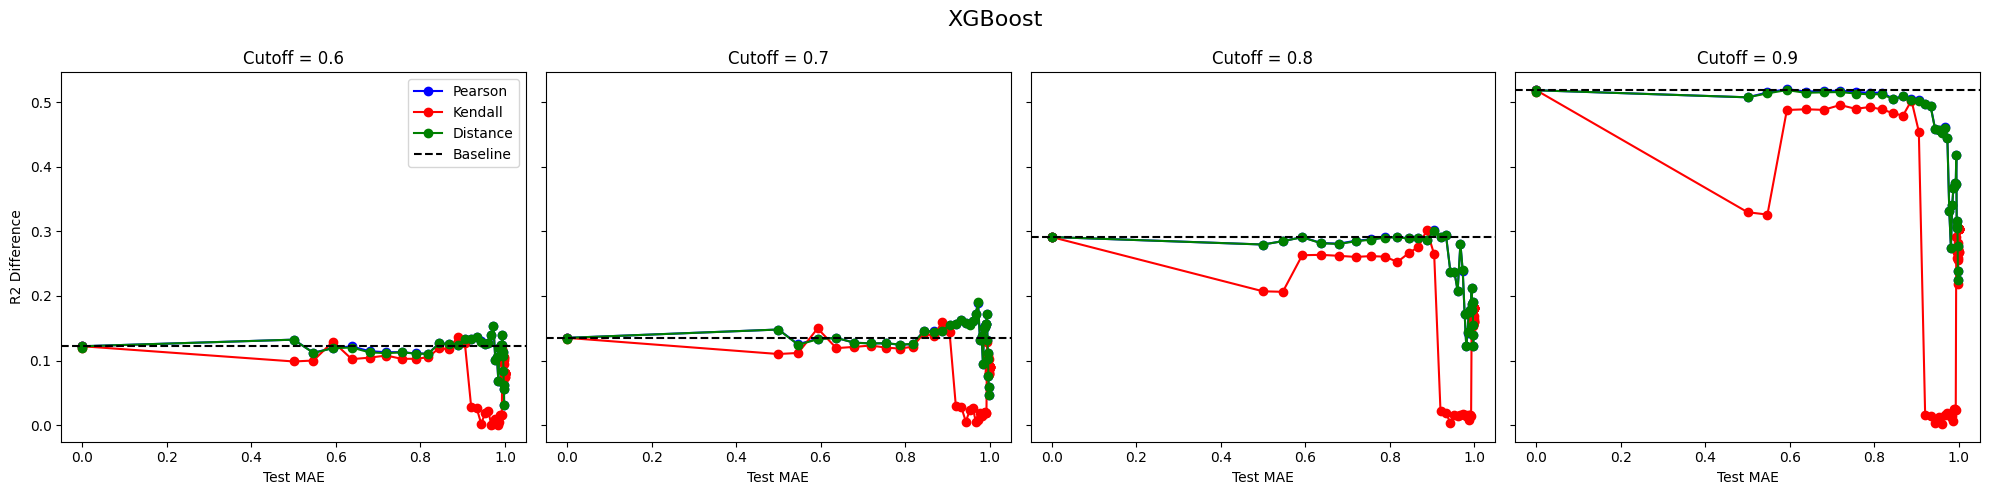

In [10]:
cut_inds = rf_data[x_axis] < 120
pearson_inds = (rf_data['correction'] == 'pearson') | (rf_data['correction'] == 'none')
kendall_inds = (rf_data['correction'] == 'kendall') | (rf_data['correction'] == 'none')
distance_inds = (rf_data['correction'] == 'distance') | (rf_data['correction'] == 'none')
pearson_inds &= cut_inds
kendall_inds &= cut_inds
distance_inds &= cut_inds

fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
ax[0].plot(rf_data[pearson_inds][x_axis] - xgb_initial, rf_data[pearson_inds]['r2 diff 0.6'], label='Pearson', color='blue', marker='o')
ax[1].plot(rf_data[pearson_inds][x_axis] - xgb_initial, rf_data[pearson_inds]['r2 diff 0.7'], color='blue', marker='o')
ax[2].plot(rf_data[pearson_inds][x_axis] - xgb_initial, rf_data[pearson_inds]['r2 diff 0.8'], color='blue', marker='o')
ax[3].plot(rf_data[pearson_inds][x_axis] - xgb_initial, rf_data[pearson_inds]['r2 diff 0.9'], color='blue', marker='o')
ax[0].plot(rf_data[kendall_inds][x_axis] - xgb_initial, rf_data[kendall_inds]['r2 diff 0.6'], label='Kendall', color='red', marker='o')
ax[1].plot(rf_data[kendall_inds][x_axis] - xgb_initial, rf_data[kendall_inds]['r2 diff 0.7'], color='red', marker='o')
ax[2].plot(rf_data[kendall_inds][x_axis] - xgb_initial, rf_data[kendall_inds]['r2 diff 0.8'], color='red', marker='o')
ax[3].plot(rf_data[kendall_inds][x_axis] - xgb_initial, rf_data[kendall_inds]['r2 diff 0.9'], color='red', marker='o')
ax[0].plot(rf_data[distance_inds][x_axis] - xgb_initial, rf_data[distance_inds]['r2 diff 0.6'], label='Distance', color='green', marker='o')
ax[1].plot(rf_data[distance_inds][x_axis] - xgb_initial, rf_data[distance_inds]['r2 diff 0.7'], color='green', marker='o')
ax[2].plot(rf_data[distance_inds][x_axis] - xgb_initial, rf_data[distance_inds]['r2 diff 0.8'], color='green', marker='o')
ax[3].plot(rf_data[distance_inds][x_axis] - xgb_initial, rf_data[distance_inds]['r2 diff 0.9'], color='green', marker='o')
# Plot dotted baseline at initial point
ax[0].axhline(y=rf_data['r2 diff 0.6'].iloc[0], linestyle='--', color='black', label='Baseline')
ax[1].axhline(y=rf_data['r2 diff 0.7'].iloc[0], linestyle='--', color='black')
ax[2].axhline(y=rf_data['r2 diff 0.8'].iloc[0], linestyle='--', color='black')
ax[3].axhline(y=rf_data['r2 diff 0.9'].iloc[0], linestyle='--', color='black')

for a in ax:
    a.set_xlabel('Test MAE')
    if x_axis_as_increase:
        a.set_xscale('log')
    # a.set_ylim(-0.02, 0.55)
ax[0].set_ylabel('R2 Difference')
ax[0].set_title('Cutoff = 0.6')
ax[0].legend()
ax[1].set_title('Cutoff = 0.7')
ax[2].set_title('Cutoff = 0.8')
ax[3].set_title('Cutoff = 0.9')
# Set figure title
fig.suptitle('XGBoost', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('.', 'figures', 'rf_mae.png'), dpi=300, bbox_inches='tight')
plt.show()

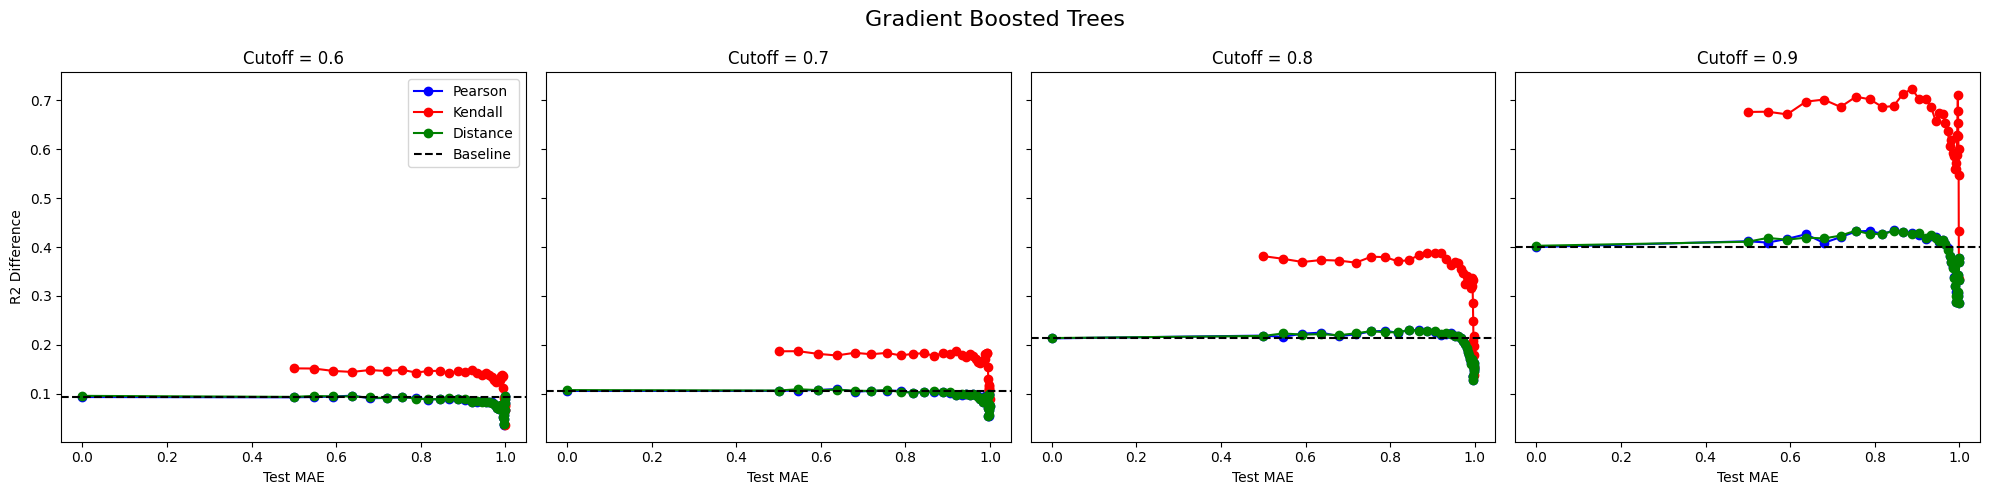

In [11]:
cut_inds = gbt_data[x_axis] <0.999
pearson_inds = (gbt_data['correction'] == 'pearson')
kendall_inds = (gbt_data['correction'] == 'kendall')
distance_inds = (gbt_data['correction'] == 'distance')
pearson_inds &= cut_inds
kendall_inds &= cut_inds
distance_inds &= cut_inds

fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
ax[0].plot(gbt_data[pearson_inds][x_axis] - xgb_initial, gbt_data[pearson_inds]['r2 diff 0.6'], label='Pearson', color='blue', marker='o')
ax[1].plot(gbt_data[pearson_inds][x_axis] - xgb_initial, gbt_data[pearson_inds]['r2 diff 0.7'], color='blue', marker='o')
ax[2].plot(gbt_data[pearson_inds][x_axis] - xgb_initial, gbt_data[pearson_inds]['r2 diff 0.8'], color='blue', marker='o')
ax[3].plot(gbt_data[pearson_inds][x_axis] - xgb_initial, gbt_data[pearson_inds]['r2 diff 0.9'], color='blue', marker='o')
ax[0].plot(gbt_data[kendall_inds][x_axis] - xgb_initial, gbt_data[kendall_inds]['r2 diff 0.6'], label='Kendall', color='red', marker='o')
ax[1].plot(gbt_data[kendall_inds][x_axis] - xgb_initial, gbt_data[kendall_inds]['r2 diff 0.7'], color='red', marker='o')
ax[2].plot(gbt_data[kendall_inds][x_axis] - xgb_initial, gbt_data[kendall_inds]['r2 diff 0.8'], color='red', marker='o')
ax[3].plot(gbt_data[kendall_inds][x_axis] - xgb_initial, gbt_data[kendall_inds]['r2 diff 0.9'], color='red', marker='o')
ax[0].plot(gbt_data[distance_inds][x_axis] - xgb_initial, gbt_data[distance_inds]['r2 diff 0.6'], label='Distance', color='green', marker='o')
ax[1].plot(gbt_data[distance_inds][x_axis] - xgb_initial, gbt_data[distance_inds]['r2 diff 0.7'], color='green', marker='o')
ax[2].plot(gbt_data[distance_inds][x_axis] - xgb_initial, gbt_data[distance_inds]['r2 diff 0.8'], color='green', marker='o')
ax[3].plot(gbt_data[distance_inds][x_axis] - xgb_initial, gbt_data[distance_inds]['r2 diff 0.9'], color='green', marker='o')
# Plot dotted baseline at initial point
ax[0].axhline(y=gbt_data['r2 diff 0.6'].iloc[0], linestyle='--', color='black', label='Baseline')
ax[1].axhline(y=gbt_data['r2 diff 0.7'].iloc[0], linestyle='--', color='black')
ax[2].axhline(y=gbt_data['r2 diff 0.8'].iloc[0], linestyle='--', color='black')
ax[3].axhline(y=gbt_data['r2 diff 0.9'].iloc[0], linestyle='--', color='black')

for a in ax:
    a.set_xlabel('Test MAE')
    if x_axis_as_increase:
        a.set_xscale('log')
    # a.set_ylim(-0.02, 0.55)
ax[0].set_ylabel('R2 Difference')
ax[0].set_title('Cutoff = 0.6')
ax[0].legend()
ax[1].set_title('Cutoff = 0.7')
ax[2].set_title('Cutoff = 0.8')
ax[3].set_title('Cutoff = 0.9')
# Set figure title
fig.suptitle('Gradient Boosted Trees', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('.', 'figures', 'gbt_mae.png'), dpi=300, bbox_inches='tight')
plt.show()